In [2]:
%matplotlib

Using matplotlib backend: <object object at 0x112cc2ba0>


In [3]:
import mne
from pprint import pprint
import json
import csv
import numpy as np
import pandas as pd
from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs, corrmap)
from pathlib import Path

In [111]:
root_data_path = Path('/Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg')
sub_idINT = 15

eeg_data_path = root_data_path / Path('S%.2d' %sub_idINT)
#print(eeg_data_path)

raw_fname = eeg_data_path / Path('S%.2d_alice-raw.fif' %sub_idINT)

raw = mne.io.read_raw_fif(raw_fname)

raw.load_data()
raw.plot()
print(raw.info)
print(raw.info["ch_names"])




Opening raw data file /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg/S15/S15_alice-raw.fif...
    Range : 0 ... 368799 =      0.000 ...   737.598 secs
Ready.
Reading 0 ... 368799  =      0.000 ...   737.598 secs...
Opening raw-browser...
Using pyopengl with version 3.1.6
<Info | 11 non-empty values
 bads: []
 ch_names: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...
 chs: 61 EEG, 2 Stimulus
 custom_ref_applied: True
 dig: 61 items (61 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 200.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 63
 projs: []
 sfreq: 500.0 Hz
>
['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60

In [112]:
# filter and exclude certain channels
n_raw = raw.copy()
n_raw.resample(sfreq=250)
#n_raw.filter(0.1, 30, phase='zero-double')  # 再加0.1~30** / 1~30(訊號被扭曲的機率會更大) ，再重跑ICA
n_raw.set_eeg_reference(['29'])  # which channels
n_raw.pick_types(eeg=True, stim=False, exclude=['29', 'VEOG', 'AUD'])  #'M1', 'M2'

n_raw.plot()

# remove dc-offset

1 events found
Event IDs: [1]
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-12 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)



/var/folders/dt/yj00f34n5x52_p314tnwfjkw0000gn/T/ipykernel_14184/1016250738.py:3: RuntimeWarning: Resampling of the stim channels caused event information to become unreliable. Consider finding events on the original data and passing the event matrix as a parameter.
  n_raw.resample(sfreq=250)


EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


In [114]:
#### WE NEED TO USE THE CUT FILE TO PERFORM ICA!!!

# set montage????? yes!!!
#ten_twenty_montage = mne.channels.make_standard_montage('standard_1020')
#n_raw.set_montage(ten_twenty_montage, match_case=False)

# ICA
ica_ = ICA(n_components = 15, random_state=97)
ica_.fit(n_raw)

# plot ICA
#n_raw.plot_sensors(sphere = (0.0, 0.02, 0.0, 0.065))

ica_.plot_sources(n_raw)
ica_.plot_components(sphere = (0.0, 0.02, 0.0, 0.065))  # What is this sphere for??
#ica_.plot_overlay(n_raw, exclude=[0,2])

Fitting ICA to data using 60 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 17.0s.
Creating RawArray with float64 data, n_channels=15, n_times=184400
    Range : 0 ... 184399 =      0.000 ...   737.596 secs
Ready.
Opening ica-browser...
Using pyopengl with version 3.1.6


[<MNEFigure size 1950x1463 with 15 Axes>]

Closing ica-browser...


Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


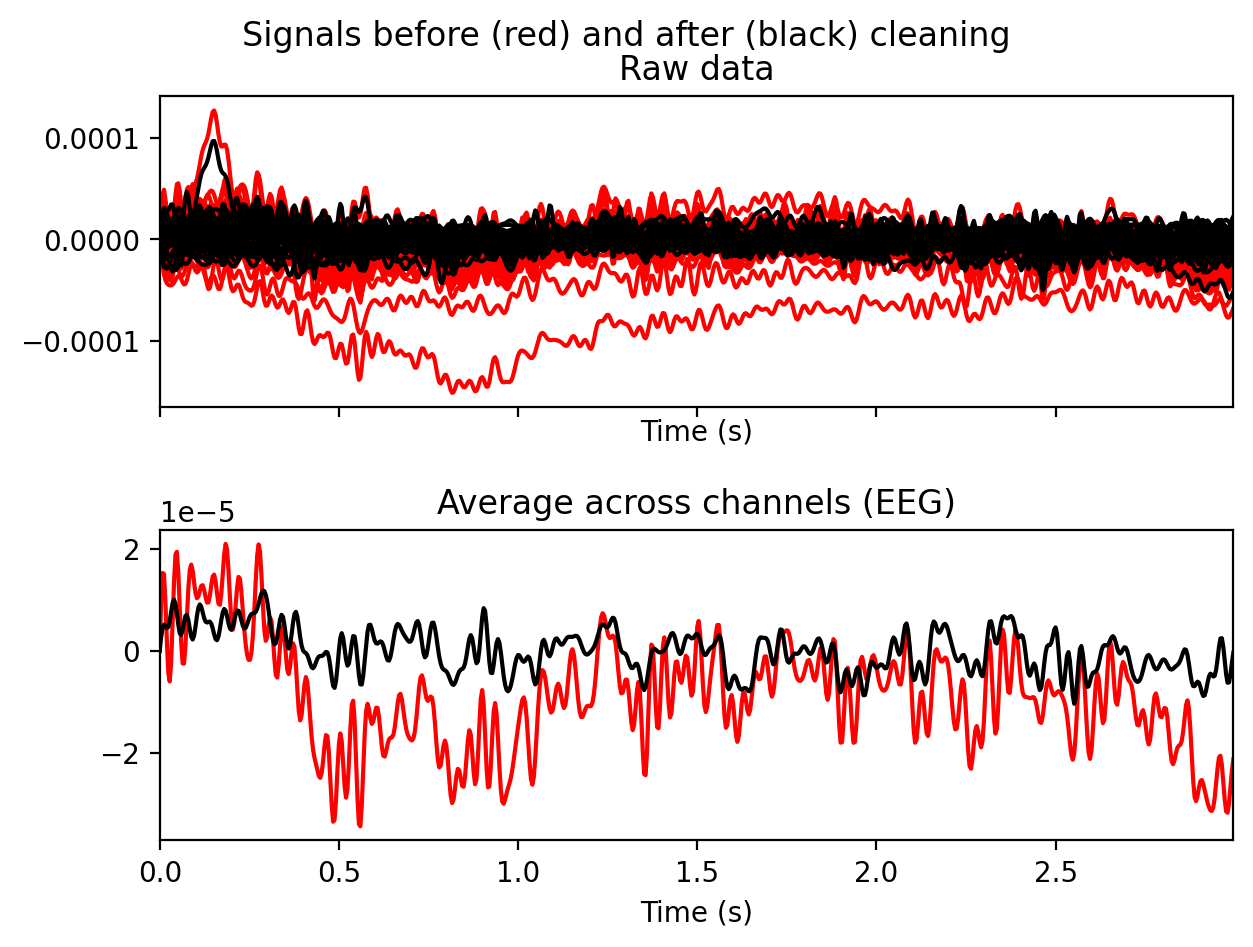

In [122]:
ica_.plot_overlay(n_raw, exclude=[0, 11])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components


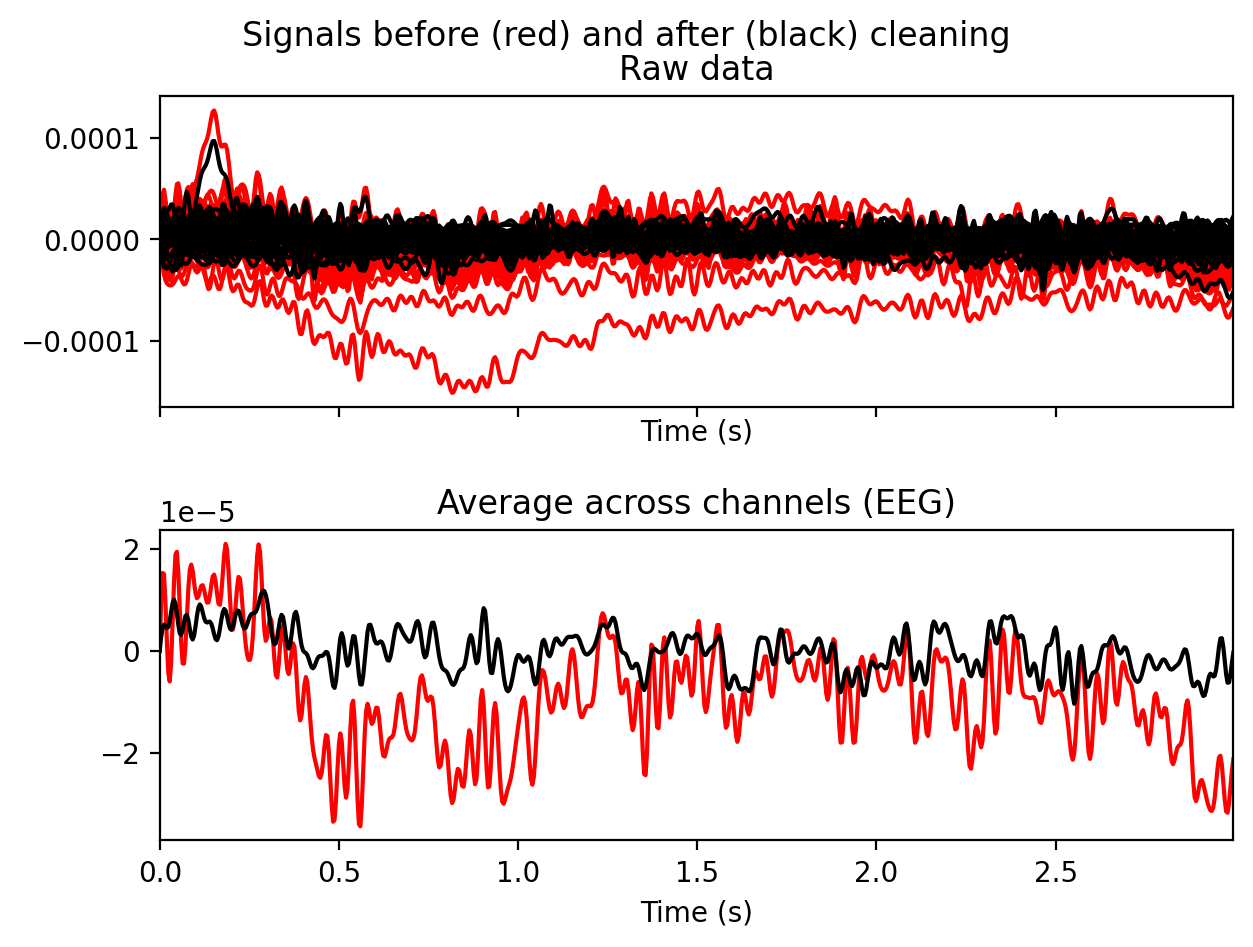

In [121]:
#ica_.plot_overlay(n_raw, exclude=[1, 2, 3, 4, 5, 6, 8, 10])  # 11
#ica_.plot_overlay(n_raw, exclude=[1, 2, 3, 4, 5, 6, 8, 10])
#ica_.plot_overlay(n_raw, exclude=[1, 2, 3, 4, 5, 6, 8])
#ica_.plot_overlay(n_raw, exclude=[1, 2, 3, 4, 5, 6])
#ica_.plot_overlay(n_raw, exclude=[1, 2, 3, 4, 5])
ica_.plot_overlay(n_raw, exclude=[0, 2, 3, 11])
ica_.plot_overlay(n_raw, exclude=[0, 2, 3])
ica_.plot_overlay(n_raw, exclude=[0, 2])
ica_.plot_overlay(n_raw, exclude=[0, 11])

In [115]:
for i in range(15):
    #ica_.plot_properties(n_raw, picks=[i])
    ica_.plot_overlay(n_raw, exclude=[i])

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 60 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 I

In [93]:
excludeICA_cLIST = []
for component in range(15):
    excludeICA_cLIST.append(component)
    print("Pic", component+1, "Exclude =", excludeICA_cLIST, ", added", component)
    ica_.plot_overlay(n_raw, exclude=excludeICA_cLIST)


Pic 1 Exclude = [0] , added 0
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 55 PCA components
Pic 2 Exclude = [0, 1] , added 1
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 55 PCA components
Pic 3 Exclude = [0, 1, 2] , added 2
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 3 ICA components
    Projecting back using 55 PCA components
Pic 4 Exclude = [0, 1, 2, 3] , added 3
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 4 ICA components
    Projecting back using 55 PCA components
Pic 5 Exclude = [0, 1, 2, 3, 4] , added 4
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 5 ICA components
    Projecting back using 55 PCA components
Pic 6 Exclude = [0, 1, 2, 3, 4, 5] , added 5
Applying ICA to 

'\nica_.plot_overlay(n_raw, exclude=[0, 1, 2, 3, 4, 6, 7, 8, 10]))  # 11\nica_.plot_overlay(n_raw, exclude=[0, 1, 2, 3, 4, 7]) \nica_.plot_overlay(n_raw, exclude=[0, 1, 2, 3, 4])\nica_.plot_overlay(n_raw, exclude=[0, 1, 2, 3])\nica_.plot_overlay(n_raw, exclude=[0, 1, 2])\nica_.plot_overlay(n_raw, exclude=[0, 1])\nica_.plot_overlay(n_raw, exclude=[0])\n'

In [123]:
#### What the hack is this?????

# This is the properties of each component
#ica_.plot_properties(n_raw, picks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

# apply the cleaned ICA to the data 
ica_.exclude = [0, 11]

raw_ICAed = n_raw.copy()
ica_.apply(raw_ICAed)
raw_ICAed.plot()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 60 PCA components
Opening raw-browser...
Using pyopengl with version 3.1.6


Closing raw-browser...
Channels marked as bad:
none


In [124]:
# Save the ICAed data into fif file
fif_data_path = root_data_path/'Alice_natives_ICAed_fif'
raw_ICAed.save(fif_data_path/Path('S%.2d_Alice-natives_ICAed_raw.fif' %sub_idINT), overwrite=True)

Writing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg/Alice_natives_ICAed_fif/S15_Alice-natives_ICAed_raw.fif
Closing /Volumes/Neurolang_1/Master Program/New_Thesis_topic/Alice_TRF(EEG dataset_fif)/Data/eeg/Alice_natives_ICAed_fif/S15_Alice-natives_ICAed_raw.fif
[done]


In [11]:
def tpoints2sec(timepointsINT, sampling_rateINT):
    '''
    turn the timepoints to time (second, s) by divided by the sampling rate 
    >> mne.events_from_annotations(raw) >> event array[0]
    '''
    time_secFLOAT = timepointsINT/sampling_rateINT
    
    return time_secFLOAT

In [14]:
trigger_tPointsNDArray, event_idDICT = mne.events_from_annotations(raw_ICAed.copy())
print(trigger_tPointsNDArray)
#print(event_idDICT)

tmpLIST = []
for t_point in trigger_tPointsNDArray:
    onsetINT64 = t_point[0]
    timeFLOAT = tpoints2sec(onsetINT64, 250)
    tmpLIST.append(timeFLOAT)
print(type(np.array(tmpLIST)))
print(type(tmpLIST[0]))

"""
for time_c in range(0, len(tmpLIST)-1):
    start_tFLOAT64 = tmpLIST[time_c]
    end_tFLOAT64 = tmpLIST[time_c+1]
    dur_tFLOAT64 = end_tFLOAT64 - start_tFLOAT64
    print(dur_tFLOAT64)
   """ 


Used Annotations descriptions: ['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9']
[[  1748      0      1]
 [ 16156      0      5]
 [ 31384      0      6]
 [ 47212      0      7]
 [ 64723      0      8]
 [ 81309      0      9]
 [ 97266      0     10]
 [113007      0     11]
 [127347      0     12]
 [141667      0      2]
 [156995      0      3]
 [171052      0      4]]
<class 'numpy.ndarray'>
<class 'numpy.float64'>


'\nfor time_c in range(0, len(tmpLIST)-1):\n    start_tFLOAT64 = tmpLIST[time_c]\n    end_tFLOAT64 = tmpLIST[time_c+1]\n    dur_tFLOAT64 = end_tFLOAT64 - start_tFLOAT64\n    print(dur_tFLOAT64)\n   '